In [1]:
%matplotlib inline
from fermi_model import * 

states10 = csv_to_states_from_filename(filename='states10.csv')
scores = Fermi.get_scores(states10)

In [3]:
from typing import Callable

def simpson(x_0: float, x_N: float, func: Callable, N: int=10000):
    """シンプソン法による積分計算"""
    h = (x_N - x_0) / N
    S = 0
    for i in range(N//2):
        # if i == 0: # func(x_0 + 2 * i * h) == func(scores[0])となり、この値の計算ではzeroDivisionとなってしまう
        #     S += h/3 * (1 + 4*func(x_0 + (2*i + 1)*h) + func(x_0 + (2*i + 2)*h))
        # else:
        #     S += h/3 * (func(x_0 + 2 * i * h) + 4*func(x_0 + (2*i + 1)*h) + func(x_0 + (2*i + 2)*h))
        S += h/3 * (func(x_0 + 2 * i * h) + 4*func(x_0 + (2*i + 1)*h) + func(x_0 + (2*i + 2)*h))
    return S

def approx_degeneracy_func(score: int, score_0: int):
    """エネルギー準位密度の近似式（ρ(ε) ∝ 1/(ε-E_0) * exp(√ε-E_0)）"""
    E = score - score_0
    if E == 0: # 基底状態のエネルギー準位密度は 1 とする
        return 1
    return np.exp(2 * np.sqrt(np.pi**2 * E / 6)) / np.sqrt(48) / E

# 縮退度で平均するときに使用する
def calc_approx_degeneracies(states: list[State]) -> list[float]:
    """近似した縮退度を計算"""
    scores = Fermi.get_scores(states)
    score_0 = scores[0]
    return [approx_degeneracy_func(score, score_0) for score in scores]

In [4]:
def outflux(score: int, score_0: int, score_max: int, Te: float, ne: float) -> int:
    C_out = ne * Te**(-0.5) * simpson(score, score_max, lambda x: approx_degeneracy_func(x, score_0) * np.exp(-(x - score)/Te))
    F_out = ne * Te**(-0.5) * simpson(score_0, score, lambda x: approx_degeneracy_func(x, score_0))
    A_out = simpson(score_0, score, lambda x: approx_degeneracy_func(x, score_0) * (score - x)**3)
    return C_out + F_out + A_out

def influx(score, partial_scores: list[int], partial_dist: list[int], Te: float, ne: float):
    score_0 = partial_scores[0]
    total_influx = 0
    for x, n in zip(partial_scores, partial_dist):
        total_influx += approx_degeneracy_func(x, score_0) * n * ne * Te**(-0.5) * np.exp(-(score - x)/Te)
    return total_influx


In [5]:
def calc_approx_dist(scores: list[int], Te:float, ne: float):
    approx_dist = [1]
    score_0 = scores[0]
    score_max = scores[-1]

    for i, score in enumerate(scores[1:]):
        n = influx(score, scores[:i+1], approx_dist, Te, ne) / outflux(score, score_0, score_max, Te, ne)
        approx_dist.append(n)
    approx_dist[0] = 1 - sum(approx_dist[1:])
    return approx_dist


In [72]:
ne = 10
Te = 0.5

In [73]:
approx_dist = calc_approx_dist(scores, Te, ne)
approx_mean_dist = np.array(approx_dist) / np.array(calc_approx_degeneracies(states10))

In [64]:
fermi = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-11)
scores_fermi, mean_dist = fermi.calc_mean_distribution()

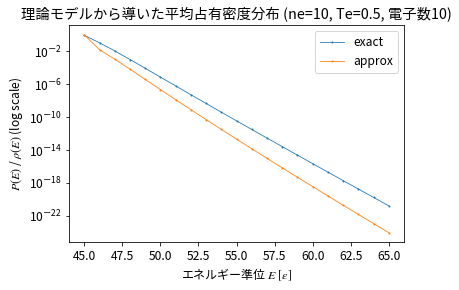

In [74]:
plt.plot(scores_fermi, mean_dist, marker='.', linewidth=0.8, ms=2, label='exact')
plt.plot(scores, approx_mean_dist, marker='.', linewidth=0.8, ms=2, label='approx')
plt.title("理論モデルから導いた平均占有密度分布 (ne=10, Te=0.5, 電子数10)")
plt.legend()
plt.yscale("log")
plt.xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
plt.ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
plt.show()

### 問題として考えられること
* 基底状態の占有密度をとりあえず 1 としてしまっていることが響いている
* ne=10, Te=0.5のとき、基底状態より一つ上の準位で、衝突脱励起を無視してしまっていることが痛い？
  * ne, Teの値をそれぞれ固定して何が原因かを突き止める。
  * Teの値が大きいほど基底状態が支配的ではなくなる
  * neの値が小さいほど基底状態以外の準位での衝突励起以外のinfluxが大きくなる

## Teを変えて行う

In [5]:
ne = 10
Te = 0.1
# ただ Te = 0.1のときならば、influx-outfluxの図から、outfluxの衝突励起は考えなくていい

In [6]:
approx_dist_Te_01 = calc_approx_dist(scores, Te, ne)
approx_mean_dist_Te_01 = np.array(approx_dist_Te_01) / np.array(calc_approx_degeneracies(states10))

In [7]:
fermi_Te_01 = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-15)
scores_fermi, mean_dist_Te_01 = fermi_Te_01.calc_mean_distribution()

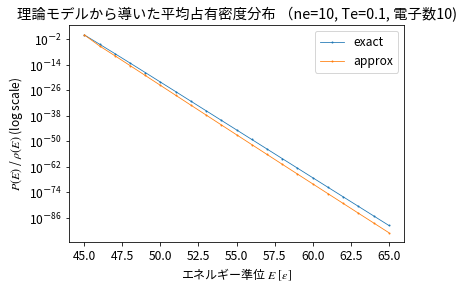

In [17]:
plt.plot(scores_fermi, mean_dist_Te_01, marker='.', linewidth=0.8, ms=2, label='exact')
plt.plot(scores, approx_mean_dist_Te_01, marker='.', linewidth=0.8, ms=2, label='approx')
plt.title("理論モデルから導いた平均占有密度分布 （ne=10, Te=0.1, 電子数10)")
plt.legend()
plt.yscale("log")
plt.xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
plt.ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
plt.show()

In [13]:
ne = 10
Te = 0.3
# ただ Te = 0.1のときならば、influx-outfluxの図から、outfluxの衝突励起は考えなくていい

In [14]:
approx_dist_Te_03 = calc_approx_dist(scores, Te, ne)
approx_mean_dist_Te_03 = np.array(approx_dist_Te_03) / np.array(calc_approx_degeneracies(states10))

In [15]:
fermi_Te_03 = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-14)
scores_fermi, mean_dist_Te_03 = fermi_Te_03.calc_mean_distribution()

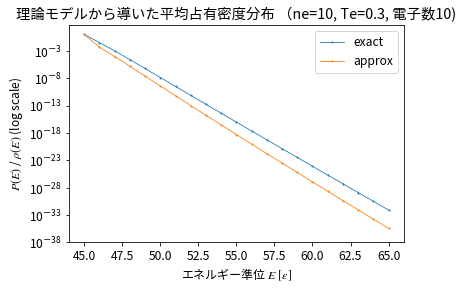

In [30]:
plt.plot(scores_fermi, mean_dist_Te_03, marker='.', linewidth=0.8, ms=2, label='exact')
plt.plot(scores, approx_mean_dist_Te_03, marker='.', linewidth=0.8, ms=2, label='approx')
plt.title("理論モデルから導いた平均占有密度分布 （ne=10, Te=0.3, 電子数10)")
plt.legend()
plt.yscale("log")
plt.ylim(1e-38, 50)
plt.xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
plt.ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
plt.show()

In [8]:
ne = 1
Te = 0.3
# ただ Te = 0.1のときならば、influx-outfluxの図から、outfluxの衝突励起は考えなくていい

In [9]:
approx_dist_Te_03_ne_1 = calc_approx_dist(scores, Te, ne)
approx_mean_dist_Te_03_ne_1 = np.array(approx_dist_Te_03_ne_1) / np.array(calc_approx_degeneracies(states10))

KeyboardInterrupt: 

In [ ]:
fermi_Te_03_ne_1 = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-14)
scores_fermi, mean_dist_Te_03_ne_1 = fermi_Te_03_ne_1.calc_mean_distribution()

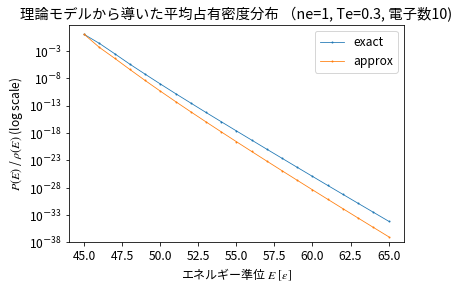

In [ ]:
plt.plot(scores_fermi, mean_dist_Te_03_ne_1, marker='.', linewidth=0.8, ms=2, label='exact')
plt.plot(scores, approx_mean_dist_Te_03_ne_1, marker='.', linewidth=0.8, ms=2, label='approx')
plt.title("理論モデルから導いた平均占有密度分布 （ne=1, Te=0.3, 電子数10)")
plt.legend()
plt.yscale("log")
plt.ylim(1e-38, 50)
plt.xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
plt.ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
plt.show()

## 検証結果
* 基底状態が支配的としていることで誤差を生んでいるのか、衝突脱励起によるinfluxを考えてないから誤差が生じているのかはわからなかった
  * Teを固定してneを小さくしたら、衝突脱励起の割合も小さくなるし、基底状態もより支配的になるので、どちらの影響で占有密度の誤差が小さくなったのかわからない

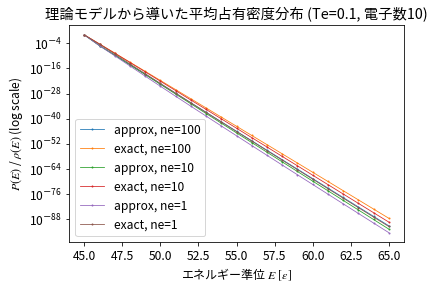

In [35]:
Te = 0.1
ne_lst = [100, 10, 1]

for ne in ne_lst:
    approx_dist = calc_approx_dist(scores, Te, ne)
    approx_mean_dist = np.array(approx_dist) / np.array(calc_approx_degeneracies(states10))
    fermi = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-13)
    scores_fermi, mean_dist = fermi.calc_mean_distribution()
    plt.plot(scores, approx_mean_dist, marker='.', linewidth=0.8, ms=2, label=f'approx, ne={ne}')
    plt.plot(scores_fermi, mean_dist, marker='.', linewidth=0.8, ms=2, label=f'exact, ne={ne}')

plt.title(f"理論モデルから導いた平均占有密度分布 (Te={Te}, 電子数10)")
plt.legend()
plt.yscale("log")
plt.xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
plt.ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
plt.show()

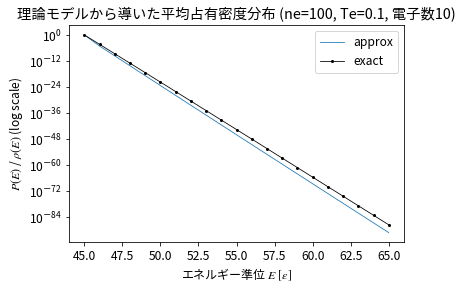

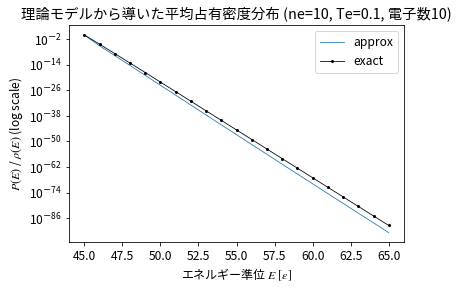

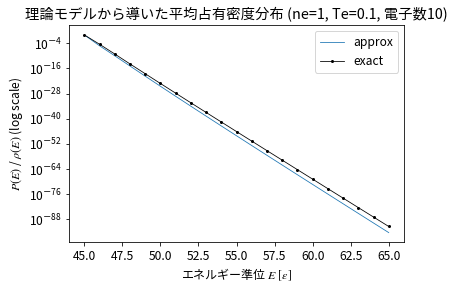

In [39]:
Te = 0.1
ne_lst = [100, 10, 1]

for ne in ne_lst:
    approx_dist = calc_approx_dist(scores, Te, ne)
    approx_mean_dist = np.array(approx_dist) / np.array(calc_approx_degeneracies(states10))
    fermi = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-13)
    scores_fermi, mean_dist = fermi.calc_mean_distribution()
    plt.plot(scores, approx_mean_dist, linewidth=0.8, label='approx', color="orange")
    plt.plot(scores_fermi, mean_dist, marker='.', linewidth=0.8, ms=4, label='exact', color="black")
    plt.title(f"理論モデルから導いた平均占有密度分布 (ne={ne}, Te={Te}, 電子数10)")
    plt.legend()
    plt.yscale("log")
    plt.xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
    plt.ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
    plt.show()

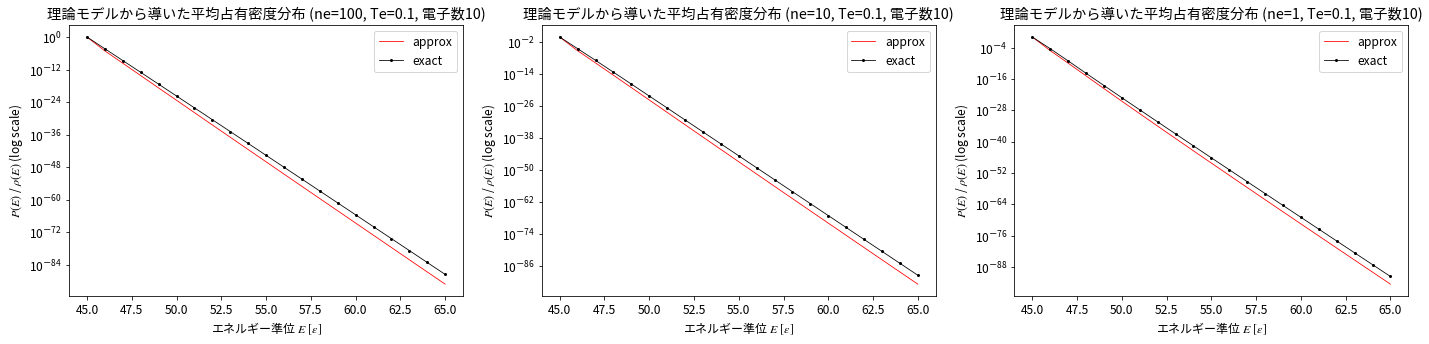

In [7]:
Te = 0.1
ne_lst = [100, 10, 1]

fig = plt.figure(figsize=(24, 5))
for i, ne in enumerate(ne_lst):
    approx_dist = calc_approx_dist(scores, Te, ne)
    approx_mean_dist = np.array(approx_dist) / np.array(calc_approx_degeneracies(states10))
    fermi = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-13)
    scores_fermi, mean_dist = fermi.calc_mean_distribution()
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(scores, approx_mean_dist, linewidth=0.8, label='approx', color="red")
    ax.plot(scores_fermi, mean_dist, marker='.', linewidth=0.8, ms=4, label='exact', color="black")
    ax.set_title(f"理論モデルから導いた平均占有密度分布 (ne={ne}, Te={Te}, 電子数10)")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
    ax.set_ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
plt.show()

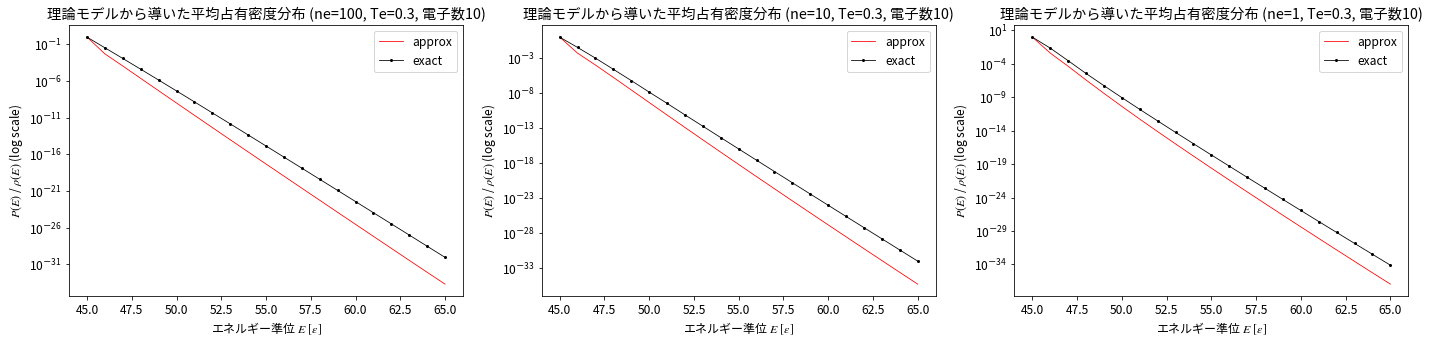

In [10]:
Te = 0.3
ne_lst = [100, 10, 1]

fig = plt.figure(figsize=(24, 5))
for i, ne in enumerate(ne_lst):
    approx_dist = calc_approx_dist(scores, Te, ne)
    approx_mean_dist = np.array(approx_dist) / np.array(calc_approx_degeneracies(states10))
    fermi = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-13)
    scores_fermi, mean_dist = fermi.calc_mean_distribution()
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(scores, approx_mean_dist, linewidth=0.8, label='approx', color="red")
    ax.plot(scores_fermi, mean_dist, marker='.', linewidth=0.8, ms=4, label='exact', color="black")
    ax.set_title(f"理論モデルから導いた平均占有密度分布 (ne={ne}, Te={Te}, 電子数10)")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
    ax.set_ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
plt.show()

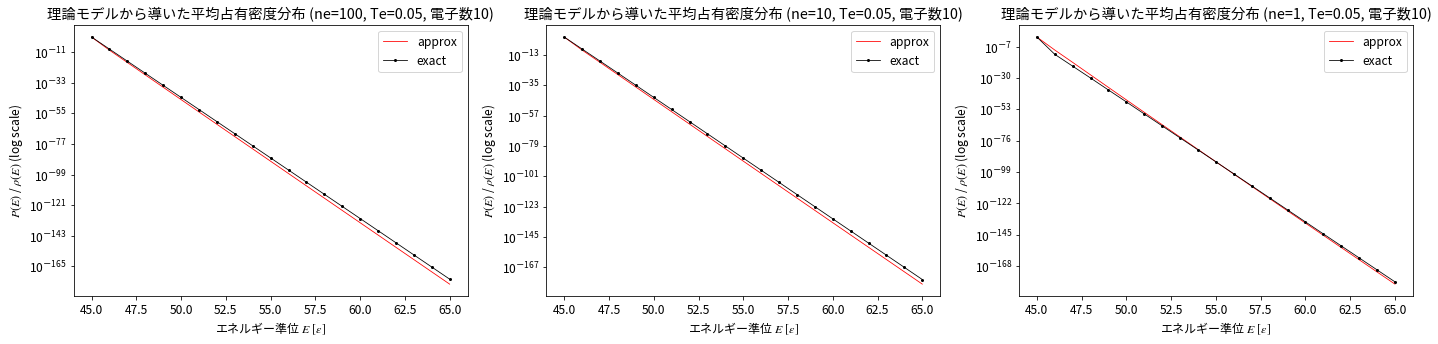

In [11]:
Te = 0.05
ne_lst = [100, 10, 1]

fig = plt.figure(figsize=(24, 5))
for i, ne in enumerate(ne_lst):
    approx_dist = calc_approx_dist(scores, Te, ne)
    approx_mean_dist = np.array(approx_dist) / np.array(calc_approx_degeneracies(states10))
    fermi = Fermi(states10, equ=False, Te=Te, ne=ne, threshold=1e-13)
    scores_fermi, mean_dist = fermi.calc_mean_distribution()
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(scores, approx_mean_dist, linewidth=0.8, label='approx', color="red")
    ax.plot(scores_fermi, mean_dist, marker='.', linewidth=0.8, ms=4, label='exact', color="black")
    ax.set_title(f"理論モデルから導いた平均占有密度分布 (ne={ne}, Te={Te}, 電子数10)")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(r"エネルギー準位 $E$ $[\epsilon]$")
    ax.set_ylabel(r"$P(E)$ / $\rho(E)$ (log scale)")
plt.show()